In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# set up the environment
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)  # set default figure size
sns.set_style("whitegrid")  # set default style
rng = np.random.default_rng()  # random number generator

## Quanto Model Review

Let $X$ denotes the exchange rate measured in domestic currency for a unit of foreign currency:
$$
\frac{dX}{X} = \mu_x dt + \sigma_x dB_x
$$
Let $S$ denotes the foreign asset measured in foreign currency:
$$
\frac{dS}{S} = \mu_s dt + \sigma_s dB_s
$$
where：
- $(dB_x)(dB_s) = \rho dt$
- $q$ - constant dividend yield of the foreign asset
- $r$ - risk-free interest rate in domestic currency
- $r_f$ - risk-free interest rate in foreign currency

A "**quanto**" is a derivative written on foreign asset an converted to domestic currency at a fixed exchange rate $\bar X$, i.e. $V(T) = \bar X S(T)$. The price of the quanto at time $t \le T$ is given by equation (6.7):
$$
V(t) = e^{(r_f - r - q - \rho \sigma_x \sigma_s)(T - t)} \bar X S(t)
$$
Following equation (6.14), a replication strategy for the quanto is given by:
- invest (long) $V(t)$ units of domestic currency in the foreign asset, which means buying $\frac{V(t)}{X(t)S(t)}$ shares of the foreign asset;
- borrow (short) $V(t)$ units of domestic currency at the foreign risk-free rate $r_f$;
- invest (long) $V(t)$ units of domestic currency in the domestic risk-free asset.

## Question 6.5 Discretely-Rebalanced Quanto Hedge

Following the similar logic from "**Discretely-Rebalanced Delta Hedges**" (Section 3.10 in the textbook), the hedging strategy for the quanto can be implemented as follows:
1. At time $t_0 = 0$, the initial portfolio consists of:
    - long $V(0)$ units of domestic currency in the foreign asset, which means buying $\delta(0) = \frac{V(t_0)}{X(t_0)S(t_0)}$ shares of the foreign asset;
    - short $V(0)$ units of domestic currency at the foreign risk-free rate $r_f$;
    - long $V(0)$ units of domestic currency in the domestic risk-free asset, i.e., cash account $C(0) = V(0)$.
2. At each rebalancing time $t_i$, $i = 1, 2, \ldots, N-1$, the portfolio is rebalanced to:
    - long $\delta(t_i) = \frac{V(t_i)}{X(t_i)S(t_i)}$ shares of the foreign asset;
    - short $V(t_i)$ units of domestic currency at the foreign risk-free rate $r_f$;
    - new cash account $C(t_i)$ includes:
      - adjusting shares of the foreign asset: $- (\delta(t_i) - \delta(t_{i-1}))S(t_i)X(t_i)$;
      - adjusting short position at the foreign risk-free asset: $V(t_i) - V(t_{i-1})e^{r_f\Delta t}X(t_i)/X(t_{i-1})$;
      - continuous dividend payment from the foreign asset: $\delta(t_{i-1})S(t_{i-1})(e^{q\Delta t} - 1)X(t_{i})$;
      - accumulation/payment of interest on the cash position of domestic currency: $C(t_{i-1})e^{r\Delta t}$.
3. At date $t_N = T$, the value of the portfolio is:
   - foreign asset: $\delta(T-1)S(T)X(T)$;
   - dividend payment: $\delta(T-1)S(T-1)(e^{q\Delta t} - 1)X(T)$;
   - foreign risk-free asset: $- V(T-1)e^{r_f\Delta t}X(T)/X(T-1)$;
   - cash account: $C(T-1)e^{r\Delta t}$.
   - promised payment: $- \bar X S(T)$.

In [2]:
def Quanto_Hedge_Profit(
    X0, mu_x, sigma_x, S0, mu_s, sigma_s, q, r, r_f, rho, X_bar, T, N
):
    dt = T / N  # time step
    t = np.linspace(0, T, N + 1)  # time grid
    # two sets of standard normal random numbers
    z1 = rng.standard_normal(size=N)
    z2 = rng.standard_normal(size=N)
    # two Brownian motions with correlation rho
    B1, B2 = np.zeros(N + 1), np.zeros(N + 1)
    B1[1:] = np.cumsum(np.sqrt(dt) * z1)
    B2[1:] = np.cumsum(np.sqrt(dt) * (rho * z1 + np.sqrt(1 - rho**2) * z2))
    # simulate the exchange rate
    X = X0 * np.exp((mu_x - 0.5 * sigma_x**2) * t + sigma_x * B1)
    # simulate the foreign asset prices
    S = S0 * np.exp((mu_s - 0.5 * sigma_s**2 - q) * t + sigma_s * B2)
    # quanto values
    V = np.exp((r - r_f - q - rho * sigma_s * sigma_x * t)
               * (T - t)) * S * X_bar
    # number of shares invested in foreign asset
    δ = V / (S * X)
    # cash position in domestic currency
    cash = np.zeros(N + 1)
    cash[0] = V[0]
    # rebalancing the portfolio from time 1 to N-1
    for i in range(1, N):
        cash[i] = (
            (cash[i - 1] * np.exp(r * dt))  # cash accumulation/payment
            + (δ[i - 1] * S[i - 1] * (np.exp(q * dt) - 1) * X[i])  # dividend
            - ((δ[i] - δ[i - 1]) * S[i] * X[i])  # foreign asset purchase/sale
            + (
                V[i] - V[i - 1] * np.exp(r_f * dt) * X[i] / X[i - 1]
            )  # foreign risk-free asset purchase/sale
        )
    # portfolio value at maturity time N
    cash[N] = (
        (cash[N - 1] * np.exp(r * dt))  # cash accumulation/payment
        + (δ[N - 1] * S[N - 1] * (np.exp(q * dt) - 1) * X[N])  # dividend
        + (δ[N - 1] * S[N] * X[N])  # foreign asset sale
        - (
            V[N - 1] * np.exp(r_f * dt) * X[N] / X[N - 1]
        )  # payment of foreign risk-free asset
    )
    profit = cash[N] - X_bar * S[N]  # profit at maturity
    return profit


def Simulate_Quanto_Hedge_Profit(P, M):
    profits = np.zeros(M)
    for i in range(M):
        profits[i] = Quanto_Hedge_Profit(*P)
    return profits

In [3]:
# Parameters
X0 = 0.5  # initial exchange rate
mu_x = 0.05  # drift of exchange rate
sigma_x = 0.2  # volatility of exchange rate

S0 = 100  # initial foreign asset
mu_s = 0.1  # drift of foreign asset
sigma_s = 0.2  # volatility of foreign asset
q = 0.01  # dividend yield of foreign asset

r = 0.02  # risk-free rate in domestic currency
r_f = 0.02  # risk-free rate in foreign currency
rho = 0  # correlation between two Brownian motions
X_bar = 0.5  # fixed exchange rate of the quanto
T = 1  # maturity
N = 252  # number of periods
M = 10000  # number of simulations

# Simulation
quato_hedge_profits = Simulate_Quanto_Hedge_Profit([X0, mu_x, sigma_x, S0, mu_s, sigma_s, q, r, r_f, rho, X_bar, T, N], M)

Percentiles of profits:
1th percentile: -0.32
5th percentile: -0.22
25th percentile: -0.09
50th percentile: -0.00
75th percentile: 0.09
95th percentile: 0.22
99th percentile: 0.32


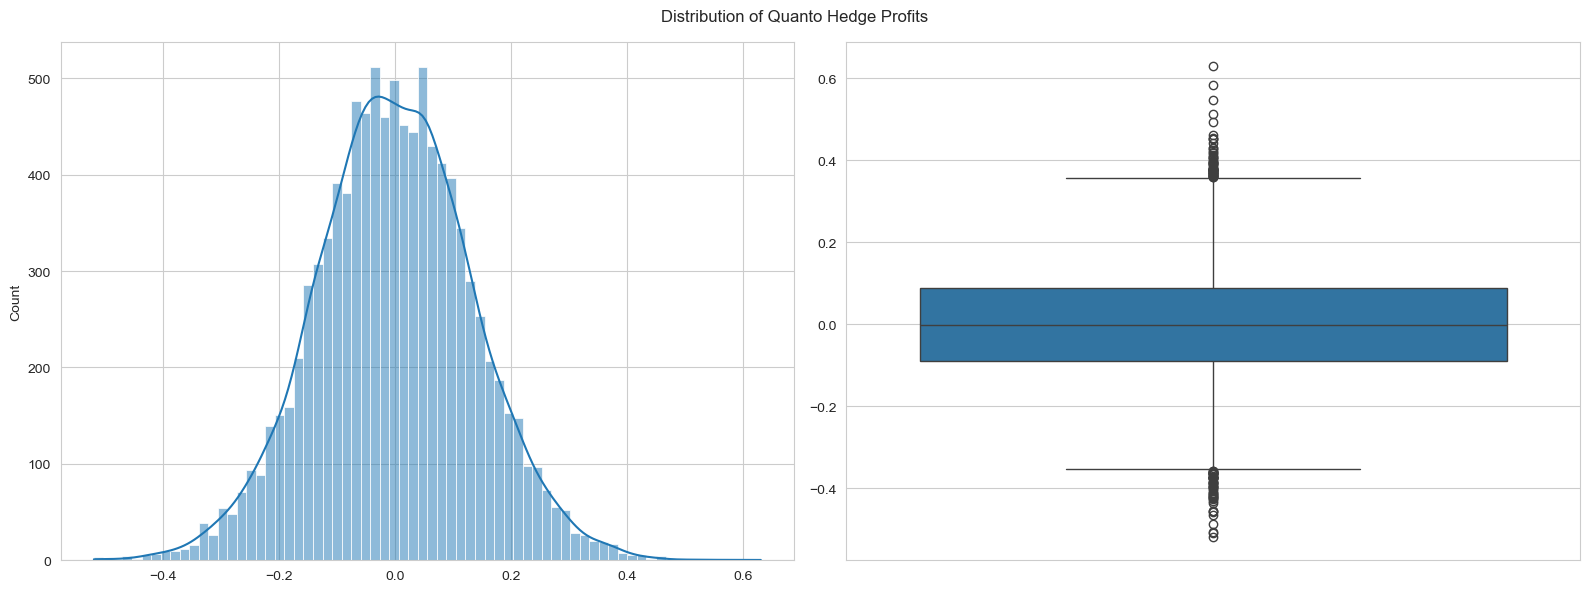

In [4]:
# Percentiles
percentiles = np.percentile(quato_hedge_profits, [1, 5, 25, 50, 75, 95, 99])
print("Percentiles of profits:")
for i, p in enumerate([1, 5, 25, 50, 75, 95, 99]):
    print(f"{p}th percentile: {percentiles[i]:.2f}")

# Distribution of profits in histogram and boxplot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(quato_hedge_profits, kde=True, ax=ax[0])
sns.boxplot(quato_hedge_profits, ax=ax[1])
fig.suptitle("Distribution of Quanto Hedge Profits")
fig.tight_layout()
plt.show()

## Question 7.7 Discretely-Rebalanced Delta Hedges for Foward Call Option

As stated in Sect. 7.6 in the textbook, the delta-hedge portfolio for a written call option (option maturing at $T$, forward maturing at $T^{\prime}$, and $T < T^{\prime}$) consists of:
- Long $F(0) N(d_1) - K N(d_2)$ units of the discounted bond maturing at $T^{\prime}$
- Long $N(d_1)$ forward contracts.

This is a zero-cost portfolio when we include the proceeds from selling the call. Since forward contracts were worth zero at initiation, we don't need to adjust the bond position at each rebalancing time, because there is no other cash flow before the maturity.

The change of forward contracts position at each rebalancing time result in a cash flow of $x(t_{i-1})[F(t_i) - F(t_{i-1})]$ dollars to be received at forward maturity $T^{\prime}$ (see, Sect. 7.10 in the textbook), where $x(t)$ is the required hedge position of forward contract. So, the profit of the hedging strategy at option maturity $T$ is:
$$
\text{Profit} = P(T, T^{\prime}) \times \left[F(0) N(d_1) - K N(d_2)\right] + P(T, T^{\prime}) \times \sum_{i=1}^{N} x(t_{i-1})\left[F(t_i) - F(t_{i-1})\right] - P(T, T^{\prime}) \times \max(F(T) - K, 0)
$$

In [5]:
def Black_Call_Delta(F, K, sigma, T):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    δ_F = norm.cdf(d1)
    δ_P = F * norm.cdf(d1) - K * norm.cdf(d2)
    return δ_F, δ_P


def Black_Call_Hedge_Profit(F0, K, mu, sigma, y, T, T_p, N):
    dt = T / N  # time step
    t = np.linspace(0, T, N + 1)  # time grid
    # Brownian motion B(t)
    B = np.zeros(N + 1)
    dB = np.sqrt(dt) * rng.standard_normal(size=N)
    B[1:] = np.cumsum(dB)
    # Forward price F(t)
    F = F0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * B)
    # Discount bond price P(t, T')
    P = np.exp(-y * (T_p - t))
    # Positions of forward contract and discounted bond to hedge the call option
    δ_F, δ_P = Black_Call_Delta(F[:-1], K, sigma, T - t[:-1])
    # Cumulative cash flow at maturity T' from the change value of the forward contracts
    dF = np.zeros(N + 1)
    for i in range(1, N + 1):
        dF[i] = dF[i - 1] + δ_F[i - 1] * (F[i] - F[i - 1])
    # portfolio value at option maturity T
    profit = δ_P[0] * P[N] + dF[N] * P[N] - max(F[N] - K, 0) * P[N]
    return profit


def Simulate_Black_Call_Hedge_Profit(P, M):
    profits = np.zeros(M)
    for i in range(M):
        profits[i] = Black_Call_Hedge_Profit(*P)
    return profits

In [6]:
# Parameters
F0 = 100  # initial forward price
K = 100  # strike price
mu = 0.05  # drift of the forward price
sigma = 0.2  # volatility of the forward price
y = 0.05  # constant yields of the discount bond
T = 0.5  # maturity of the call option
T_p = 1  # maturity of the forward contract
N = 252  # number of periods
M = 10000  # number of simulations

# Simulation
profits = Simulate_Black_Call_Hedge_Profit([F0, K, mu, sigma, y, T, T_p, N], M)

Percentiles of profits
1th percentile: -0.83
5th percentile: -0.50
25th percentile: -0.17
50th percentile: -0.00
75th percentile: 0.17
95th percentile: 0.49
99th percentile: 0.78


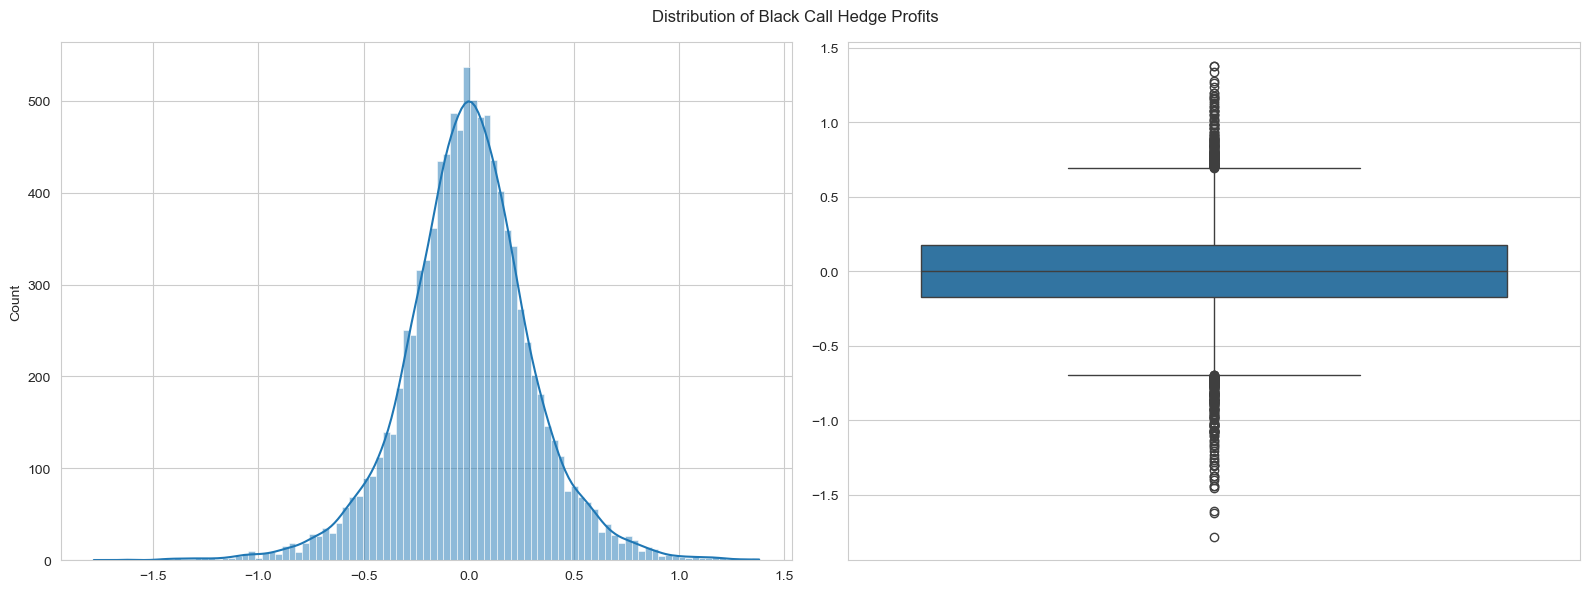

In [7]:
# Percentiles
percentiles = np.percentile(profits, [1, 5, 25, 50, 75, 95, 99])
print("Percentiles of profits")
for i, p in enumerate([1, 5, 25, 50, 75, 95, 99]):
    print(f"{p}th percentile: {percentiles[i]:.2f}")

# Distribution of profits in histogram and boxplot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(profits, kde=True, ax=ax[0])
sns.boxplot(profits, ax=ax[1])
fig.suptitle("Distribution of Black Call Hedge Profits")
fig.tight_layout()
plt.show()